In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from keras.utils import to_categorical
import random

In [2]:
train_data = pd.read_excel("/Users/changyuean/Desktop/Quantiphi Case Study/Training sheet.xlsx")

In [3]:
train_data.head()

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9
2,119870115,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9
3,119590115,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9
4,91700115,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9


Since id is not useful in the classification task, so I will delete id first

In [4]:
train_data = train_data.drop(['id'],axis=1)

In [5]:
train_data.head()

,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9
2,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9
3,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9
4,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9


In [6]:
# since the 'total' column is highly correlated with Category and it doesn't exit in the test dataset, 
# so I will drop it.
train_data['total'].corr(train_data['Category'])

0.8054966083826666

In [7]:
train_data = train_data.drop(['total'],axis=1)

In [8]:
train_data.head()

,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,Category
0,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,9
1,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,9
2,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,9
3,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,9
4,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,9


In [9]:
#For movies names, it could have positive impact or negative impact or no impact on the category
#For customers and investors, they know Harry Potter very well based on the previous movies or the book.
#Another good example is Avatar. Investor cannot know what is Avatar just based on the name. 
#They need to look at the movie descriptions, movies lines, background stories etc to understand this movie.
#As a result, movie name and display name do not have any impact in this case
train_data = train_data.drop(['name'], axis =1)
train_data = train_data.drop(['display_name'], axis = 1)

In [10]:
train_data.head()

,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,Category
0,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,9
1,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,9
2,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,9
3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,9
4,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,9


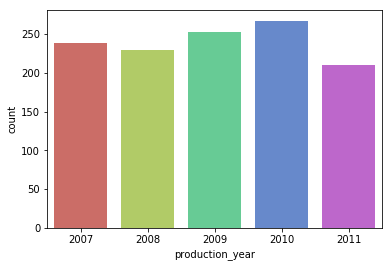

<Figure size 432x288 with 0 Axes>

In [11]:
#see the distribution of the year
sns.countplot(x='production_year',data=train_data,palette='hls')
plt.show()
plt.savefig('count_plot')
#based on the result, the movies are well distributed by different years

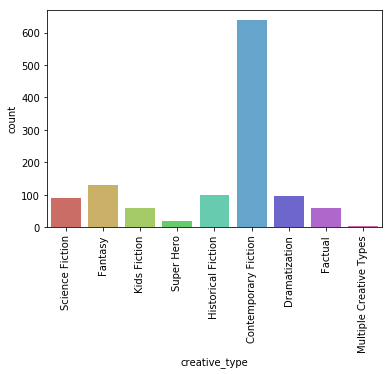

<Figure size 432x288 with 0 Axes>

In [12]:
#see the distribution of creative type
sns.countplot(x='creative_type',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#most of the movies are contemporary fiction, but there are other movies in other creative types

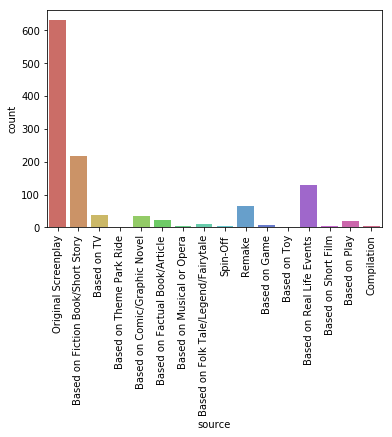

<Figure size 432x288 with 0 Axes>

In [13]:
#see the distribution of the source
sns.countplot(x='source',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#most of the movies are "original screenplay", but there are movies from other sources

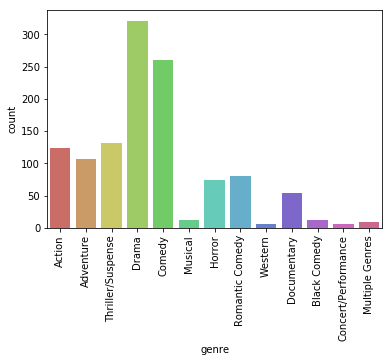

<Figure size 432x288 with 0 Axes>

In [14]:
#see the distribution of the genre
sns.countplot(x='genre',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#based on the result, the movies genres are well distributed

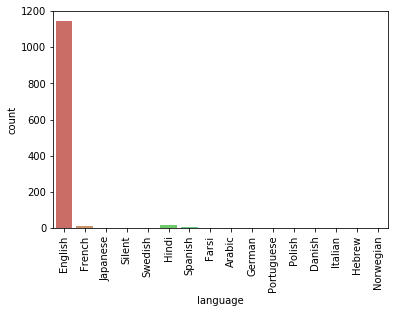

<Figure size 432x288 with 0 Axes>

In [15]:
#see the distribution of the language
sns.countplot(x='language',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#based on the result, almost all movies are English. So language is not a good variable for prediction

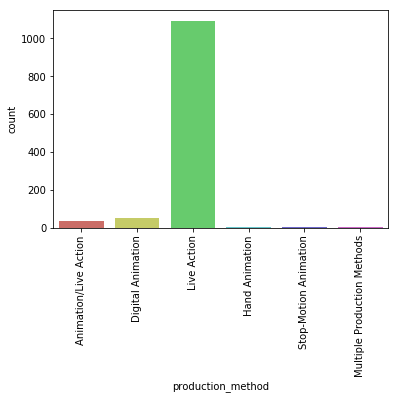

<Figure size 432x288 with 0 Axes>

In [47]:
#see the distribution of the product method
sns.countplot(x='production_method',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#based on the result, almost all movies are Live Action. I will keep this variable so far.

In [17]:
#see the unique values in the board_rating_reason
train_data["board_rating_reason"].unique()
#there are so many unique values in this variable, and they are only descriptive words of the movie rating
#so they are not very useful in this case, so we can delete it
train_data = train_data.drop(['board_rating_reason'],axis =1)

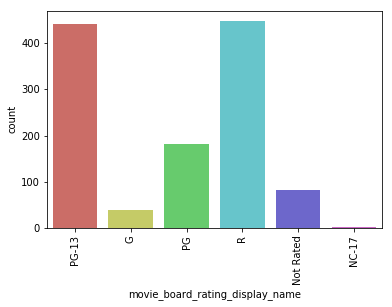

<Figure size 432x288 with 0 Axes>

In [18]:
#see the distribution of the movie board rating display name
sns.countplot(x='movie_board_rating_display_name',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#based on the result, the movies are well distributed to different ratings

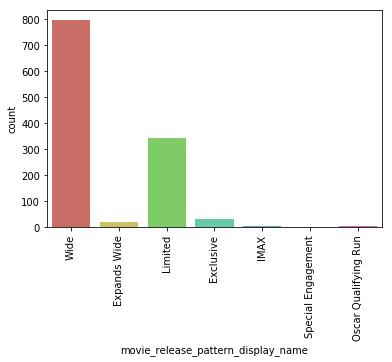

<Figure size 432x288 with 0 Axes>

In [19]:
#see the distribution of the movie_release_pattern_display_name
sns.countplot(x='movie_release_pattern_display_name',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#based on the result, majority of the movies are Wide, but there are some movies in Limited, Expands Wide and Exclusive

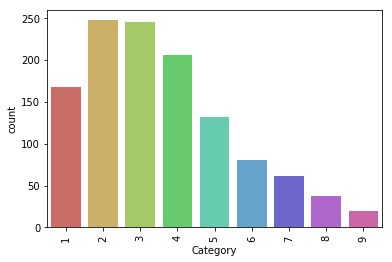

<Figure size 432x288 with 0 Axes>

In [20]:
#see the distribution of the Category
sns.countplot(x='Category',data=train_data,palette='hls')
plt.xticks(rotation=90)
plt.show()
plt.savefig('count_plot')
#based on the result, Category is well distributed

In [21]:
#Drop language 
train_data = train_data.drop(['language'], axis = 1)

In [22]:
#transfer product year from int to categorical data
train_data['production_year'] = train_data['production_year'].astype('object')

In [23]:
print(np.shape(train_data))
train_data.head()

(1196, 9)


,production_year,movie_sequel,creative_type,source,production_method,genre,movie_board_rating_display_name,movie_release_pattern_display_name,Category
0,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,PG-13,Wide,9
1,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,PG-13,Wide,9
2,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,PG-13,Wide,9
3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,G,Wide,9
4,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,PG-13,Wide,9


From above results, we can see that there 1196 examples in the dataset and 9 variables. We need to transform the variables into dummy variables.

In [24]:
#create a dummy variable if it is categorical data and drop categorical columns
def create_dummy(data_input):
    var=None
    column_name=list(data_input.columns)
    for var in column_name:
        if data_input[var].dtypes == 'object':
            cat_list='var'+'_'+var
            cat_list = pd.get_dummies(data_input[var], prefix=var)
            data_input1=data_input.join(cat_list)
            data_input=data_input1
            data_input=data_input.drop([var],axis=1)
    return data_input

In [25]:
data_input = create_dummy(train_data)
print(np.shape(data_input))
data_input.head()

(1196, 64)


,movie_sequel,Category,production_year_2007,production_year_2008,production_year_2009,production_year_2010,production_year_2011,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,...,movie_board_rating_display_name_PG,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide
0,0,9,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,9,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1,9,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,9,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,9,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# Softmax Classifier with One-layer Neural Network

Based on the target variable "Category", we can see that it has multiple different values. As a result, this is a classification problem. In order to classify "Category", the first algorithm I will use is Softmax regression, aka multinomial logistic regression. For the Softmax regression, we can think it as a one layer, k neurons (in this case, k = 9) neural network. Below is an example of one-layer neural network with Softmax activation function for the output layer.

<img src="Softmax_classifier.png" alt="Drawing" style="width: 400px;"/>

Image is from: http://eric-yuan.me/simple-deep-network/

Before starting to code the softmax regression algorithm, I will do "one-hot coding" for the targeted variable Category. The reason that I am doing the one-hot coding is the output of the softmax regression is a matrix in (1196,9) dimension. Without using Softmax classifier if the prediction is [0, 0.6, 0.4, 0.4, 0.4, 0.4, 0, 0.6, 0.7], the predict process will predict every data point which is above 0.5 as 1 [0, 1, 0, 0, 0, 0, 1, 1]. As a consequence, the movie is in category 2, 8, and 9, which is impossible. 

What Softmax function does is use exp(z1)/Σ[exp(z1)+exp(z2)+...+exp(z9]. As a result, the softmax prediction will be 
[0, 0.1538, 0.1026, 0.1026, 0.1026, 0.1026, 0, 0.1538, 0.1795]. So we can see that Category 9 has the highest number, so argmax = 9.

In [26]:
def onehot(data):
    
    data_with_dummy= create_dummy(data)
    dataY = data_with_dummy['Category']
    dataX = data_with_dummy.drop(['Category'],axis = 1)
    
    data_one_hot_Y = to_categorical(dataY)
    data_one_hot_Y = data_one_hot_Y[:,1:10] #drop the column 0
    dataX = np.asarray(dataX)
    
    return dataX, data_one_hot_Y


In [27]:
dataX, data_one_hot_Y = onehot(train_data)
print(data_one_hot_Y.shape)
print(dataX.shape)

(1196, 9)
(1196, 63)


After doing one-hot coding, then we split the data into train (72%), dev (18%), and test set (10%).

In [28]:
#transform the data from Pandas Frame to numpy array and split into Train, Dev and Test Set
def data_preprocess(data):
    
    dataX, data_one_hot_Y= onehot(data)
    #split train, dev, and test datasets
    x_train, x_test, y_train, y_test = train_test_split(dataX, data_one_hot_Y, test_size=0.1, random_state=0)
    
    return x_train, x_test, y_train, y_test
    

In [29]:
def kfold_split(k,x_train,y_train):
    kf = KFold(n_splits=k, random_state=0)
    all_kfold_trainX = []
    all_kfold_testX = []
    all_kfold_trainY = []
    all_kfold_testY = []
    for train_index, test_index in kf.split(x_train):
        kfold_trainX, kfold_testX = x_train[train_index], x_train[test_index]
        kfold_trainY, kfold_testY = y_train[train_index], y_train[test_index]
        all_kfold_trainX.append(kfold_trainX)
        all_kfold_testX.append(kfold_testX)
        all_kfold_trainY.append(kfold_trainY)
        all_kfold_testY.append(kfold_testY)
    
    return all_kfold_trainX, all_kfold_testX, all_kfold_trainY, all_kfold_testY

After splitting the data, we start to build the Softmax regression algorithm.
For the (i)th specific node, the prediction ŷ = exp(z[i]) / Σ(exp(z[i]), i=1,2,3,.....,m and z[i] = w[i]*x + b

In [30]:
def softmax(x_train, W):

    Z = np.dot(x_train, W)

    soft_max = np.exp(Z)/ np.sum(np.exp(Z),axis=1, keepdims=True)
    
    return soft_max

Then, we will use the cross-entropy loss to calculate the loss function of the prediction: 
L = -Σylog(ŷ) with L2 regularization. Also, we will calculate gradient descent of W. After calculating the loss function, we will use gradient descent to update the weights W and b.

In [31]:
def cross_entropy(x, y, lambd, lr, W):
    soft_max = softmax(x,W)
    m = x.shape[0]
    loss = (-1/m)*np.sum(y*np.log(soft_max)) + (lambd/2)*np.sum(W*W) #calculate the cross entropy loss
    grad = (-1/m)*np.dot(x.T, y - soft_max) + lambd*W #calculate the gradient descent
    W = W - lr*grad #using gradient descent to update W
    return loss, grad, W

Apply softmax model on the test dataset for prediction.

In [32]:
def prediction(x_test, y_test, W):
    
    m = x_test.shape[0]
    soft_max = softmax(x_test, W)
    soft_max_maximum = np.max(soft_max,axis=1)
    soft_max_maximum = soft_max_maximum.reshape(soft_max_maximum.shape[0],1)
    pred = ((soft_max-soft_max_maximum)==0)
    result = np.zeros(x_test.shape[0])
    for i in range(x_test.shape[0]):
        result[i] = (np.sum(pred[i]==y_test[i])==9)
    
    Accuracy = np.sum(result)/m
    return Accuracy

Run the main function. In the main function, we will decide the threshold to make sure the gradient descent is going to converge. The threshold is 1e-5. Otherwise, the maximum number of iterations will be 8000. Learning rate will 0.005. Lambda will be 0.1. I just arbitrarily determined numbers for hyper-parameters. Future work will include tuning these hyper-parameters.

In [48]:
def main_softmax(data, k, maxiterations=3000, learning_rate=0.2, lambd=0.1):

    x_train, x_test, y_train, y_test = data_preprocess(data)
    
    all_kfold_trainX, all_kfold_testX, all_kfold_trainY, all_kfold_testY = kfold_split(k,x_train,y_train)
    
    all_accuracy = []
    all_weights = []
    
    for i in range(k):     
        W = np.random.randn(all_kfold_trainX[i].shape[1],9)
        soft_max = softmax(all_kfold_trainX[i], W)
        loss, grad, W = cross_entropy(all_kfold_trainX[i], all_kfold_trainY[i], lambd, learning_rate, W)
        losses = []
        losses.append(loss)
        threshold = 1e-5
        prev_loss = 0
        j=1
        while abs(prev_loss - loss)>threshold and j < maxiterations:
            soft_max = softmax(all_kfold_trainX[i], W)
            prev_loss = loss
            loss, grad, W = cross_entropy(all_kfold_trainX[i], all_kfold_trainY[i], lambd, learning_rate, W)
            j+=1
            
            """
            # Print the cost every 100 training example
            if j % 100 == 0:
                print ("Loss after iteration %i: %f" %(j, loss))
            if j % 100 == 0:
                losses.append(loss)
            """
               
        Accuracy = prediction(all_kfold_testX[i], all_kfold_testY[i], W)
        print("Accuracy is :", Accuracy, "in fold ", i)
        all_weights.append(W)
        all_accuracy.append(Accuracy)
    
    print("The mean accuracy of", k, "fold validation is: ", np.mean(all_accuracy))
    
    mean_weight = np.mean(all_weights, axis = 0)
    
    Accuracy = prediction(x_test, y_test,  mean_weight)
    print("Test Set Accuracy is :", Accuracy)
    
    return mean_weight

In [34]:
W = main_softmax(train_data, k=10, maxiterations=8000, learning_rate=0.005, lambd=0.1)

Accuracy is : 0.32407407407407407 in fold  0
Accuracy is : 0.19444444444444445 in fold  1
Accuracy is : 0.26851851851851855 in fold  2
Accuracy is : 0.2037037037037037 in fold  3
Accuracy is : 0.19444444444444445 in fold  4
Accuracy is : 0.2962962962962963 in fold  5
Accuracy is : 0.2803738317757009 in fold  6
Accuracy is : 0.2616822429906542 in fold  7
Accuracy is : 0.21495327102803738 in fold  8
Accuracy is : 0.2336448598130841 in fold  9
The mean accuracy of 10 fold validation is:  0.2472135687088958
Test Set Accuracy is : 0.275


From the Softmax regression I got 27.5% accuracy.

---

# Random Forest

Random Forest is another way of doing classification. The best of Random Forest is it is an extension over bagging. It takes one extra step where in addition to taking the random subset of data, it also takes the random selection of features rather than using all features to grow trees. According to the Bias-Variance Analysis: Variance(x) = 𝜌(𝜎^2) + (1-𝜌)/M * (𝜎^2). So as we increase the number of sample trees M, the Variance will reduce. Their ability to limit overfitting without substantially increasing error due to bias is the reaso that I am going to use this model for the case.

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
def randomforest(dev_trainX, dev_trainY, nestimators, maxdepth, minsampleleaf, minsamplesplit):
    
    #start to create the Random Forest Model
    rf_Model= RandomForestClassifier(n_estimators=nestimators, max_depth=maxdepth, min_samples_leaf= minsampleleaf,
                                 min_samples_split = minsamplesplit, random_state=0)
    
    rf_Model.fit(dev_trainX, dev_trainY)
    #print(rf_Model.feature_importances_)
    
    
    return rf_Model

In [41]:
def main_RF(data, k, nestimators, maxdepth, minsampleleaf, minsamplesplit):

    data_with_dummy = create_dummy(data)
    
    Y = data_with_dummy['Category']
    X = data_with_dummy.drop(['Category'], axis = 1)
    
    Y = np.asarray(Y)
    X = np.asarray(X)
    
    #just split original data, but not doing one-hot encoding
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
    
    
    all_kfold_trainX, all_kfold_testX, all_kfold_trainY, all_kfold_testY = kfold_split(k,x_train,y_train)
    
    best_accuracy = 0 #save the best accuracy
    best_hyperparameter = np.zeros(4) #to save the best combination of 4 different hyper-parameters
    best_model = None
    
    

    for i in range(k):
        for n in nestimators:
            for ma in maxdepth:
                for msl in minsampleleaf:
                    for mss in minsamplesplit:
                        m = all_kfold_testX[i].shape[0]
                        result = np.zeros(m)
                        rf_Model = randomforest(all_kfold_trainX[i], all_kfold_trainY[i], n, ma, msl, mss)
                        pred_result = rf_Model.predict(all_kfold_testX[i])
                        
                        #start to calculate the accuracy
                        for j in range(all_kfold_testX[i].shape[0]):
                            result[j] = (pred_result[j]==all_kfold_trainY[i][j])
                            
                        Accuracy = np.sum(result)/m
                        
                        #to figure out the best combination of the hyper-parameters
                        if Accuracy> best_accuracy:
                            best_accuracy = Accuracy
                            best_hyperparameter = [n, ma, msl, mss]
                            best_model = rf_Model
                            
                        print("Current progress of hyper-parameter tuning: ", n, ma, msl, mss, Accuracy)
                            
    print("Best",k,"fold accuracy is: ", best_accuracy)
    print("Best n-estimators: ", best_hyperparameter[0])
    print("Best max_depth: ", best_hyperparameter[1])
    print("Best min_sample_leaf: ", best_hyperparameter[2])
    print("Best min_sample_split: ", best_hyperparameter[3])
    
    #using test dataset for prediction
    pred_result = best_model.predict(x_test)
    
    m = x_test.shape[0]
    result = np.zeros(m)
    #calcuate the accuracy
    for i in range(m):
        result[i] = pred_result[i]==y_test[i]
    
    Accuracy = np.sum(result)/x_test.shape[0]
    
    print("The Test Dataset Accuracy is: ",Accuracy)
    
    return best_hyperparameter

The reason that I am tuning the parameters by using randomly generated numbers is: 

From the left figure we can see that the hyperparameters have the grid layout. The important hyperparameter will decide when to reach the optimzal points. However, since it is grid layout, so the imporant hyperparameter only be tested three combinations. But none of them reached the highest value. However, if we use random hyperparameter tuning, we can gurantee that we will test more combinations of hyperparameters. And it has much higher chance to reach the highest value.

<img src="Hyperparameter Tuning Strategy.png" alt="Drawing" style="width: 400px;"/>

Image is from the paper "Random Search for Hyper-Parameter Optimization" by James Bergstra and Yoshua Bengio

In [42]:
best_hyperparameter = main_RF(train_data, k=10, nestimators=random.sample(range(200,500), 2), maxdepth = random.sample(range(1,50), 2), 
                              minsampleleaf = random.sample(range(5,20), 2), minsamplesplit = random.sample(range(5,30), 2))

Current progress of hyper-parameter tuning:  254 39 13 6 0.14814814814814814
Current progress of hyper-parameter tuning:  254 39 13 8 0.14814814814814814
Current progress of hyper-parameter tuning:  254 39 6 6 0.16666666666666666
Current progress of hyper-parameter tuning:  254 39 6 8 0.16666666666666666
Current progress of hyper-parameter tuning:  254 7 13 6 0.1574074074074074
Current progress of hyper-parameter tuning:  254 7 13 8 0.1574074074074074
Current progress of hyper-parameter tuning:  254 7 6 6 0.19444444444444445
Current progress of hyper-parameter tuning:  254 7 6 8 0.19444444444444445
Current progress of hyper-parameter tuning:  462 39 13 6 0.16666666666666666
Current progress of hyper-parameter tuning:  462 39 13 8 0.16666666666666666
Current progress of hyper-parameter tuning:  462 39 6 6 0.16666666666666666
Current progress of hyper-parameter tuning:  462 39 6 8 0.16666666666666666
Current progress of hyper-parameter tuning:  462 7 13 6 0.18518518518518517
Current prog

Current progress of hyper-parameter tuning:  462 7 13 8 0.21495327102803738
Current progress of hyper-parameter tuning:  462 7 6 6 0.205607476635514
Current progress of hyper-parameter tuning:  462 7 6 8 0.205607476635514
Current progress of hyper-parameter tuning:  254 39 13 6 0.14018691588785046
Current progress of hyper-parameter tuning:  254 39 13 8 0.14018691588785046
Current progress of hyper-parameter tuning:  254 39 6 6 0.16822429906542055
Current progress of hyper-parameter tuning:  254 39 6 8 0.16822429906542055
Current progress of hyper-parameter tuning:  254 7 13 6 0.1588785046728972
Current progress of hyper-parameter tuning:  254 7 13 8 0.1588785046728972
Current progress of hyper-parameter tuning:  254 7 6 6 0.1588785046728972
Current progress of hyper-parameter tuning:  254 7 6 8 0.1588785046728972
Current progress of hyper-parameter tuning:  462 39 13 6 0.14953271028037382
Current progress of hyper-parameter tuning:  462 39 13 8 0.14953271028037382
Current progress of 

---

After using the random forest, I got slightly better result based on the Test Dataset Accuracy. There is one more model that I want to try, which is Deep Neural Network with Softmax activation function for the output layer. As I mentioned in the description of Softmax regression model, the initial Softmax regression was a one-lay neural network which only contains input layer and output layer (activation function is softmax). The result that I want to Deep Neural Network is Deep Neural Network could help me do feature engeering automatically.

Suppose, we have a house pricing prediction problem and we will use Deep Neural Network to solve it.

<img src="Neural Network.png" alt="Drawing" style="width: 300px;"/>

Image is from: https://www.google.com/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwiU45nYovveAhVGxoMKHXGtDGEQjB16BAgBEAQ&url=https%3A%2F%2Fwww.neuraldesigner.com%2F&psig=AOvVaw1W_iIhgju9h3Rz6RPDTFs7&ust=1543638231215045

For instance, if X1 is average income level around of the community. X2 is the criminal rate of the community. X3 is the cost of the school around this community and X4 is the number of squares of the house. So by combining them with different weights, they will generate new features for the data. For instance, by giving more weights to X1 and X3, the first neuron could stand for the school quality.

As a result, deep neural networks will use the original features to generate new features by combining different variables with different weights.

In [46]:
#in the initialization function, I will initialize W, b, and the structure of neural network
def initialization():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-46-797be2cb448c>, line 3)